<a href="https://colab.research.google.com/github/AndrejErjavec/monkey-classifier/blob/main/jordan_testmonkeydataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**we need to install kaggle first and associate our kaggle accounts. this is done with the help of the succeeding steps.** 

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

**make sure that at this stage, yuou have uploaded your kaggle.json file in the file manager section (at the left of your screen)**

In [ ]:
!mv kaggle.json ~/.kaggle

**we need to grant admin privileges so we can access the credentials embedded in this json file** 

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

**at this stage, find your dataset, copy its api command and paste it in the code below** 

In [ ]:
!kaggle datasets download -d slothkong/10-monkey-species


10-monkey-species.zip: Skipping, found more recently modified local copy (use --force to force download)


**make sure that you are in this folder before unzipping the files. or else it will be really messy** 

In [ ]:
/pwd


'/content'

**finally unzip them using the same api command**

In [ ]:
!unzip 10-monkey-species.zip -d input

Archive:  10-monkey-species.zip
  inflating: input/monkey_labels.txt  
  inflating: input/training/training/n0/n0018.jpg  
  inflating: input/training/training/n0/n0019.jpg  
  inflating: input/training/training/n0/n0020.jpg  
  inflating: input/training/training/n0/n0021.jpg  
  inflating: input/training/training/n0/n0022.jpg  
  inflating: input/training/training/n0/n0023.jpg  
  inflating: input/training/training/n0/n0024.jpg  
  inflating: input/training/training/n0/n0025.jpg  
  inflating: input/training/training/n0/n0026.jpg  
  inflating: input/training/training/n0/n0027.jpg  
  inflating: input/training/training/n0/n0028.jpg  
  inflating: input/training/training/n0/n0029.jpg  
  inflating: input/training/training/n0/n0030.jpg  
  inflating: input/training/training/n0/n0031.jpg  
  inflating: input/training/training/n0/n0032.jpg  
  inflating: input/training/training/n0/n0033.jpg  
  inflating: input/training/training/n0/n0034.jpg  
  inflating: input/training/training/n0/n0035

In [ ]:
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
import numpy as np
import glob
import PIL

In [ ]:
images = []
for img in glob.glob('./input/training/training/n0/*'):
  im = np.array(PIL.Image.open(img))
  images.append(im)

**we wanna see how many images we have**

In [ ]:
len(images)

105

**we wanna visualize and organise the set of images we have into train and test sets. this function does it for you.**

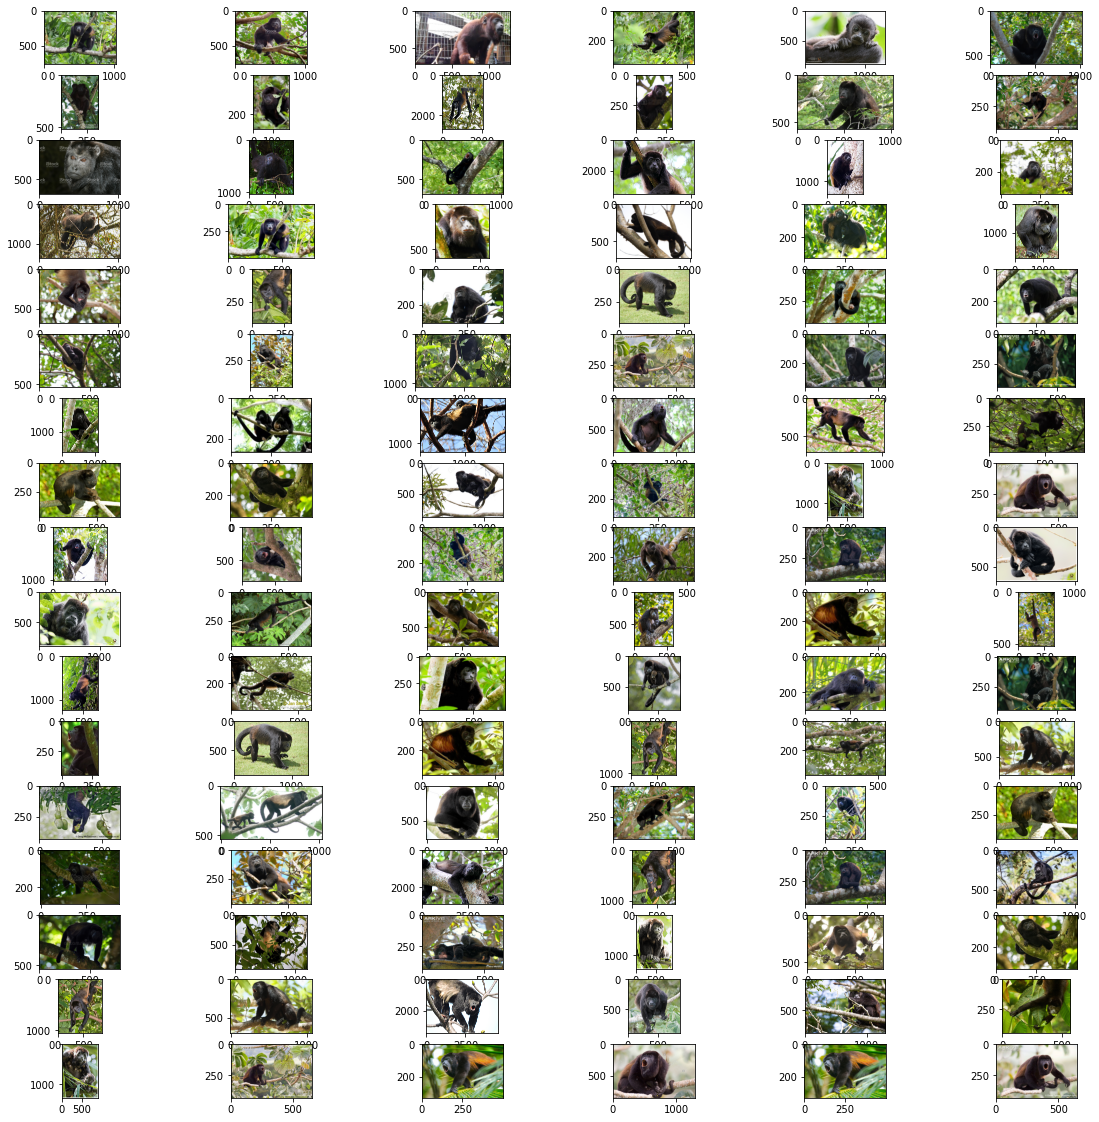

In [ ]:
fig, axes = plt.subplots(int(len(images)/6), 6, figsize=(20,20))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])

**we wanna set the directories for training and testing.**

In [ ]:
IMAGE_SHAPE=(224,224)
PATIENCE = 5
TRAINING_DATA_DIR = 'input/training/training'
VALID_DATA_DIR = 'input/validation/validation'

**now, after visualising and setting the images, we wanna create subplots**

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE
)
valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [ ]:
visualizer = tf.keras.callbacks.TensorBoard(log_dir='./tfevents')
earlystops = tf.keras.callbacks.EarlyStopping(patience=PATIENCE, 
                                              restore_best_weights=True,
                                              verbose=1
                                              )

**we define a model using keras CNN given the specific parameters - since CNN's create subimages from one big image (based on the filters).**

In [ ]:
def getModel(classes):
  model = tf.keras.Sequential(
      [
       tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3),
                              activation='relu', input_shape=(224,224,3)),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
       tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3),
                              activation='relu', input_shape=(224,224,3)),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
       tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                              activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(64, activation='relu'),
       tf.keras.layers.Dense(classes, activation='softmax'),
      ]
  )
  return model

**use this command to run the functions defined in GetModel**

In [ ]:
model = getModel(10)

**this prints a summary of the model and details of its implementation**

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 32)      

**we need to compile the model using the parameters given. ignore the warning message that you will get**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**now with this model trained, we can do a test run to see how it performs given the validation set**

In [ ]:
EPOCHS=20
BATCH_SIZE=32
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples,
    epochs=EPOCHS,
    validation_data=valid_generator, 
    validation_steps=valid_generator.samples,
    verbose=1, 
    callbacks=[visualizer, earlystops]
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1098/1098 [==============================] - 63s 55ms/step - loss: 2.2704 - accuracy: 0.1393 - val_loss: 2.2188 - val_accuracy: 0.1949


**load tensorboard to visualise this**

In [ ]:
%load_ext tensorboard
%tensorboard --log_dir './tfevents'

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for details and examples.

**to load a train model you can do something like this**

In [ ]:
loaded_model = tf.keras.models.load_model("put the pathhere.h5")

**then you can test your loaded model using these commands**

In [ ]:
predict = model.predict(images)